In [53]:
# update 20231231
# by Nick Ni

import pandas as pd 
import numpy as np
from tqdm import *
import statsmodels.api as sm

# 米筐
import rqdatac
from rqdatac import *
init()
from rqfactor import *

# 关闭通知
import warnings
warnings.filterwarnings("ignore")
#import loggings
#logging.getLogger().setLevel(logging.ERROR)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False



def get_buy_list(df,top_tpye = 'rank',rank_n = 100,quantile_q = 0.8):
    """
    :param df: 因子值 -> dataframe/unstack
    :param top_tpye: 选择买入队列方式，从['rank','quantile']选择一种方式 -> str
    :param rank_n: 值最大的前n只的股票 -> int
    :param quantile_q: 值最大的前n分位数的股票 -> float
    :return df: 买入队列 -> dataframe/unstack
    """
    if top_tpye == 'rank':
        df = df.rank(axis  = 1,ascending=False) <= rank_n
    elif top_tpye == 'quantiles':
        df = df.sub(df.quantiles(quantile_q,axis = 1),axis = 0) > 0
    else:
        print("select one from ['rank','quantile']")

    df = df.astype(int)
    df = df.replace(0,np.nan).dropna(how = 'all',axis = 1)
    
    return df


def get_bar(df):
    """
    :param df: 买入队列 -> dataframe/unstack
    :param benchmark: 基准指数 -> str
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = get_previous_trading_date(df.index.min(),1).strftime('%F')
    end_date = df.index.max().strftime('%F')
    stock_list = df.columns.tolist()
    price_open = get_price(stock_list,start_date,end_date,fields=['open']).open.unstack('order_book_id')
    
    return price_open


def get_benchmark(df,benchmark = '000985.XSHG'):
    """
    :param df: 买入队列 -> dataframe/unstack
    :param benchmark: 基准指数 -> str
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = get_previous_trading_date(df.index.min(),1).strftime('%F')
    end_date = df.index.max().strftime('%F')
    price_open = get_price([benchmark],start_date,end_date,fields=['open']).open.unstack('order_book_id')
    
    return price_open


def get_performance_analysis(account_result,name = ' ',rf = 0.03,benchmark_index = '000985.XSHG'):

    # 加入基准    
    performance = pd.concat([account_result['total_account_asset'].to_frame('strategy'),
                             get_benchmark(account_result,benchmark_index)],axis = 1)
    performance_net = performance.pct_change().dropna(how = 'all')                                # 清算至当日开盘
    performance_cumnet = (1 + performance_net).cumprod()
    performance_cumnet['alpha'] = performance_cumnet['strategy']/performance_cumnet[benchmark_index]
    performance_cumnet = performance_cumnet.fillna(1)

    # 指标计算
    performance_pct = performance_cumnet.pct_change().dropna()

    # 策略收益
    strategy_name,benchmark_name,alpha_name = performance_cumnet.columns.tolist() 
    Strategy_Final_Return = performance_cumnet[strategy_name].iloc[-1] - 1

    # 策略年化收益
    Strategy_Annualized_Return_EAR = (1 + Strategy_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 基准收益
    Benchmark_Final_Return = performance_cumnet[benchmark_name].iloc[-1] - 1

    # 基准年化收益
    Benchmark_Annualized_Return_EAR = (1 + Benchmark_Final_Return) ** (252/len(performance_cumnet)) - 1

    # alpha 
    ols_result = sm.OLS(performance_pct[strategy_name] * 252 - rf, sm.add_constant(performance_pct[benchmark_name] * 252 - rf)).fit()
    Alpha = ols_result.params[0]

    # beta
    Beta = ols_result.params[1]

    # beta_2 = np.cov(performance_pct[strategy_name],performance_pct[benchmark_name])[0,1]/performance_pct[benchmark_name].var()
    # 波动率
    Strategy_Volatility = performance_pct[strategy_name].std() * np.sqrt(252)

    # 夏普
    Strategy_Sharpe = (Strategy_Annualized_Return_EAR - rf)/Strategy_Volatility

    # 下行波动率
    strategy_ret = performance_pct[strategy_name]
    Strategy_Down_Volatility = strategy_ret[strategy_ret < 0].std() * np.sqrt(252)

    # sortino
    Sortino = (Strategy_Annualized_Return_EAR - rf)/Strategy_Down_Volatility
    
    # 跟踪误差
    Tracking_Error = (performance_pct[strategy_name] - performance_pct[benchmark_name]).std() * np.sqrt(252)

    # 信息比率
    Information_Ratio = (Strategy_Annualized_Return_EAR - Benchmark_Annualized_Return_EAR)/Tracking_Error

    # 最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[benchmark_name]) 
                    - performance_cumnet[benchmark_name])
                    /np.maximum.accumulate(performance_cumnet[benchmark_name]))
    j = np.argmax(performance_cumnet[benchmark_name][:i])
    Max_Drawdown = (1-performance_cumnet[benchmark_name][i]/performance_cumnet[benchmark_name][j])

    # 卡玛比率
    Calmar = (Strategy_Annualized_Return_EAR)/Max_Drawdown

    # 超额收益
    Alpha_Final_Return = performance_cumnet[alpha_name].iloc[-1] - 1

    # 超额年化收益
    Alpha_Annualized_Return_EAR = (1 + Alpha_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 超额波动率
    Alpha_Volatility = performance_pct[alpha_name].std() * np.sqrt(252)

    # 超额夏普
    Alpha_Sharpe = (Alpha_Annualized_Return_EAR - rf)/Alpha_Volatility

    # 超额最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[alpha_name]) 
                    - performance_cumnet[alpha_name])
                    /np.maximum.accumulate(performance_cumnet[alpha_name]))
    j = np.argmax(performance_cumnet[alpha_name][:i])
    Alpha_Max_Drawdown = (1-performance_cumnet[alpha_name][i]/performance_cumnet[alpha_name][j])

    # 胜率
    performance_pct['win'] = performance_pct[alpha_name] > 0
    Win_Ratio = performance_pct['win'].value_counts().loc[True] / len(performance_pct)

    # 盈亏比
    profit_lose = performance_pct.groupby('win')[alpha_name].mean()
    Profit_Lose_Ratio = ABS(profit_lose[True]/profit_lose[False])
    

    result = {
        'Strategy_Final_Return':round(Strategy_Final_Return,4),
        'Strategy_Annualized_Return_EAR': round(Strategy_Annualized_Return_EAR,4),
        'Benchmark_Final_Return':round(Benchmark_Final_Return,4),
        'Benchmark_Annualized_Return_EAR': round(Benchmark_Annualized_Return_EAR,4),
        'Alpha':round(Alpha,4),
        'Beta':round(Beta,4),
        'Volatility':round(Strategy_Volatility,4),
        'Sharpe':round(Strategy_Sharpe,4),
        'Down_Volatility':round(Strategy_Down_Volatility,4),
        'Sortino':round(Sortino,4),
        'Tracking_Error':round(Tracking_Error,4),
        'Information_Ratio':round(Information_Ratio,4),
        'Max_Drawdown':round(Max_Drawdown,4),
        'Calmar': round(Calmar,4),
        'Alpha_Final_Return':round(Alpha_Final_Return,4),
        'Alpha_Annualized_Return_EAR': round(Alpha_Annualized_Return_EAR,4),
        'Alpha_Volatility':round(Alpha_Volatility,4),
        'Alpha_Sharpe':round(Alpha_Sharpe,4),
        'Alpha_Max_Drawdown':round(Alpha_Max_Drawdown,4),
        'Win_Ratio':round(Win_Ratio,4),
        'Profit_Lose_Ratio':round(Profit_Lose_Ratio,4)

    }


    # 回测图绘制
    import matplotlib.pyplot as plt
    
    x = performance_cumnet.index
    y1 = performance_cumnet['strategy']
    y2 = performance_cumnet[benchmark_index]
    y3 = performance_cumnet['alpha']


    fig, ax = plt.subplots()

    ax.plot(x, y1, label='strategy',color = 'darkred')
    ax.plot(x, y2, label=benchmark_index)
    ax.plot(x, y3, label='alpha')
    plt.title(name)

    # 调整子图的布局，留出空间给表格
    plt.subplots_adjust(right=1.4, top=1.1)
    # 创建一个额外的空白子图
    # 添加表格
    cell_text =  [['指标','数值']] + [list(result.items())][0]
    table = ax.table(cellText=cell_text, loc='right')

    # 调整表格的大小
    #table.scale(0.7, 0.7)

    # 设置单元格的属性
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # 对第一行进行处理
            cell.set_text_props(fontsize=10, ha='center', va='center')  # 居中对齐
        elif j == 0:  # 对第一列进行处理
            cell.set_text_props(fontsize=10, ha='left', va='center')  # 左对齐
        else:
            cell.set_text_props(fontsize=10, ha='right', va='center')  # 右对齐

    # 设置行高
    for i in range(len(cell_text)):
        table._cells[(i, 0)].set_height(0.0454)
        table._cells[(i, 1)].set_height(0.0453)
    table.auto_set_column_width([0, 1])
    table.auto_set_font_size(False)

    # 显示图例
    ax.legend()
    plt.show()

    return result

### 含涨跌停限制

In [54]:
# 不含涨跌停
def backtest(df_weight, change_n = 20, cash = 10000 * 1000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02):

    # 基础参数
    inital_cash = cash                                                                                                            # 起始资金
    stock_holding_num_hist = 0                                                                                                    # 初始化持仓       
    buy_cost = other_tax + commission                                                                                             # 买入交易成本
    sell_cost = tax + other_tax + commission                                                                                      # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1                                                                # 现金账户利息(日)
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])           # 账户信息存储
    price_open = get_bar(df_weight)                                                                                               # 获取开盘价格数据
    stock_round_lot = pd.Series(dict([(i,instruments(i).round_lot) for i in df_weight.columns.tolist()]))                         # 标的最小买入数量
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期

    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)):
        start_date = change_day[i]
        end_date = change_day[i+1]

        # 获取给定权重
        df_weight_temp = df_weight.loc[start_date].dropna()
        stock_list_temp = df_weight_temp.index.tolist()
        # 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp 
                            * cash 
                            / (price_open.loc[start_date,stock_list_temp] * (1 + sell_cost))        # 预留交易费用
                            // stock_round_lot.loc[stock_list_temp]) 
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动
        stock_holding_num_change = stock_holding_num - stock_holding_num_hist
        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date,stock_list_temp]
        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0:
                fee_temp = -1 * x * sell_cost                                                                                       # 印花税 + 过户费等 + 佣金
            else:
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        transaction_costs = ((price_open_temp.loc[start_date] 
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date]
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account
        
        # 将当前持仓存入 
        stock_holding_num_hist = stock_holding_num
        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    account.loc[pd.to_datetime(get_previous_trading_date(account.index.min(),1))] = [inital_cash,0,inital_cash]
    account = account.sort_index()
    
    return account


100%|██████████| 35/35 [00:00<00:00, 217.69it/s]


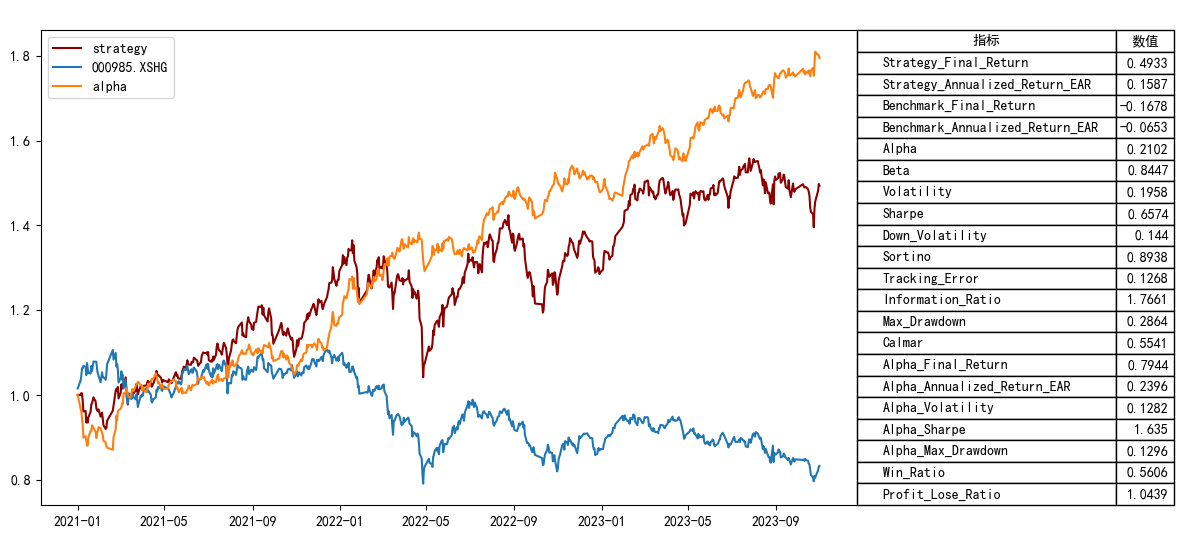

In [55]:
df = pd.read_pickle('./tech_ew_combo.pkl')
buy_list = get_buy_list(df)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
account_result = backtest(df_weight)
performance_result = get_performance_analysis(account_result)

### 含涨跌停限制

In [56]:
# 含涨跌停
def backtest(df_weight, change_n = 20, cash = 10000 * 1000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02):
    
    # 基础参数
    inital_cash = cash                                                                                                            # 起始资金
    stock_holding_num_hist = 0                                                                                                    # 初始化持仓       
    buy_cost = other_tax + commission                                                                                             # 买入交易成本
    sell_cost = tax + other_tax + commission                                                                                      # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1                                                                # 现金账户利息(日)
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])           # 账户信息存储
    price_open = get_bar(df_weight)                                                                                               # 获取开盘价格数据
    stock_round_lot = pd.Series(dict([(i,instruments(i).round_lot) for i in df_weight.columns.tolist()]))                         # 标的最小买入数量
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期
    cannot_sellable_stock_list_temp = []
    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)):

        start_date = change_day[i]
        end_date = change_day[i+1]
        
        # 计算是否存在跌停
        if i == 0:
            pass 
        else:
            buy_out_stock_list_temp = stock_holding_num_hist.index.tolist()
            price_open_limit = get_price(stock_list_temp,start_date,start_date,fields=['open','limit_down']).droplevel(1)
            cannot_sellable_stock_list_temp = sorted(price_open_limit[price_open_limit['open'] == price_open_limit['limit_down']].index.get_level_values(0))
            # 若跌停，计算冻结资金
            if len(cannot_sellable_stock_list_temp) != 0:
                cannot_sellable_cash = (stock_holding_num_hist.loc[cannot_sellable_stock_list_temp] * price_open_limit.open).dropna().sum()              # 计算冻结资金体量
                cash -= cannot_sellable_cash                                                                                                             # 刷新可用资金
                stock_holding_num_hist_cannot_sellable = stock_holding_num_hist.copy()                                                                   
                stock_holding_num_hist_cannot_sellable.loc[cannot_sellable_stock_list_temp] = 0                                                          # 修改副本记录存量为0
                print(start_date.strftime('%F'),cannot_sellable_stock_list_temp,'跌停未能卖出')

        # 获取给定权重 
        df_weight_temp = df_weight.loc[start_date].dropna()
        stock_list_temp = df_weight_temp.index.tolist()

        # 计算是否存在涨停
        price_open_limit = get_price(stock_list_temp,start_date,start_date,fields=['open','limit_up']).droplevel(1)
        stock_list_temp = sorted(price_open_limit[price_open_limit['open'] != price_open_limit['limit_up']].index.get_level_values(0))
        # 若涨停之按之前权重等比例修正买入涨停比例的股票
        df_weight_temp = df_weight_temp.loc[stock_list_temp]/df_weight_temp.loc[stock_list_temp].sum()
        # 涨停的标的输出
        cannot_buyable_stock_list_temp = sorted(price_open_limit[price_open_limit['open'] == price_open_limit['limit_up']].index.get_level_values(0))
        if len(cannot_buyable_stock_list_temp) != 0:
            print(start_date.strftime('%F'),cannot_buyable_stock_list_temp,'涨停未能买入')
        # 用剩余资金买入 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp 
                            * cash 
                            / (price_open.loc[start_date,stock_list_temp] * (1 + sell_cost))        # 预留交易费用
                            // stock_round_lot.loc[stock_list_temp]) 
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动&实际持仓(上期未能卖出)
        if (i == 0) | (len(cannot_sellable_stock_list_temp) == 0):
            stock_holding_num_change = stock_holding_num - stock_holding_num_hist
        else:
            stock_holding_num_change = stock_holding_num - stock_holding_num_hist_cannot_sellable
            stock_holding_num = stock_holding_num.add(stock_holding_num_hist.loc[cannot_sellable_stock_list_temp],fill_value = 0)
            
        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date,stock_list_temp]

        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0:
                fee_temp = -1 * x * sell_cost                                                                                       # 印花税 + 过户费等 + 佣金
            else:
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        transaction_costs = ((price_open_temp.loc[start_date] 
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date]
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account
        
        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        # 保存历史数据
        stock_holding_num_hist = stock_holding_num

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    account.loc[pd.to_datetime(get_previous_trading_date(account.index.min(),1))] = [inital_cash,0,inital_cash]
    account = account.sort_index()
    
    return account




 17%|█▋        | 6/35 [00:00<00:03,  8.12it/s]

2021-05-07 ['002321.XSHE'] 跌停未能卖出


 40%|████      | 14/35 [00:01<00:03,  6.86it/s]

2022-01-27 ['002115.XSHE'] 跌停未能卖出


 51%|█████▏    | 18/35 [00:02<00:02,  7.61it/s]

2022-05-05 ['300392.XSHE'] 跌停未能卖出


 57%|█████▋    | 20/35 [00:02<00:01,  7.78it/s]

2022-07-01 ['603758.XSHG'] 跌停未能卖出


 74%|███████▍  | 26/35 [00:03<00:01,  8.00it/s]

2022-12-26 ['002574.XSHE'] 跌停未能卖出


100%|██████████| 35/35 [00:04<00:00,  7.31it/s]


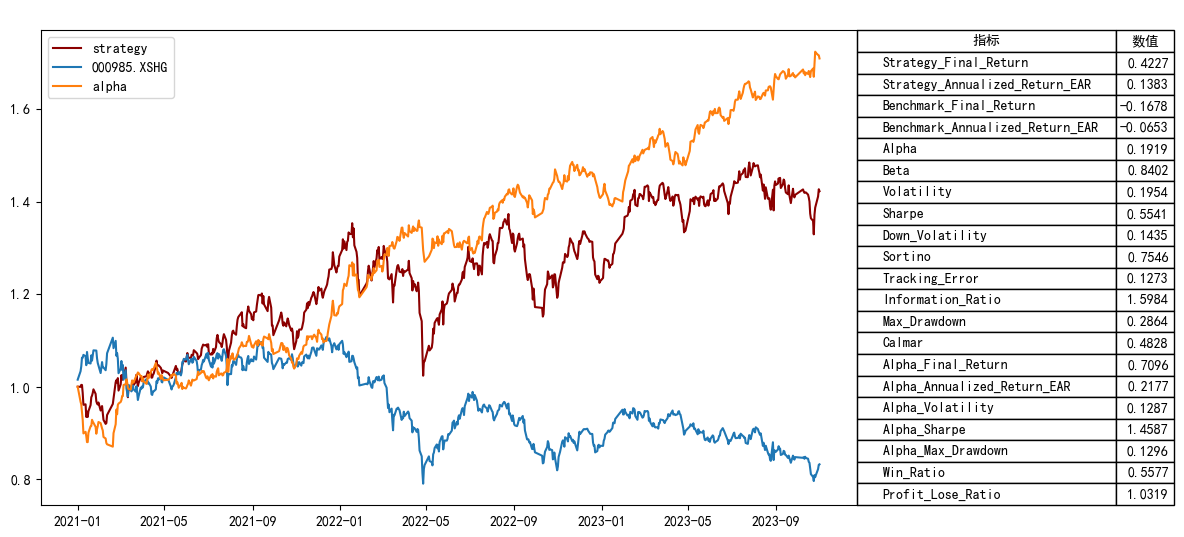

In [57]:
df = pd.read_pickle('./tech_ew_combo.pkl')
buy_list = get_buy_list(df)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
account_result = backtest(df_weight)
performance_result = get_performance_analysis(account_result)